## Diabetes in India

Over 30 million have now been diagnosed with diabetes in India. The CPR (Crude prevalence rate) in the urban areas of India is thought to be 9 per cent.

In rural areas, the prevalence is approximately 3 per cent of the total population.

The population of India is now more than 1000 million: this helps to give an idea of the scale of the problem.

The estimate of the actual number of diabetics in India is around 40 million.

This means that India actually has the highest number of diabetics of any one country in the entire world. IGT (Impaired Glucose Tolerance) is also a mounting problem in India.

[Source Link](https://www.diabetes.co.uk/global-diabetes/diabetes-in-india.html)

## As a Beginner in Data Science or into Kaggle, this Notebook will come in handy for implementing Machine Learning Models.

### Topics Covered:
- Data Analysis
- Data Scaling
- Data Modeling
- Hyper-parameter Tuning.
- Cross Validation
- Predictions

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
sns.set_style('darkgrid')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/pima-indians-diabetes-database/diabetes.csv


## 1. Daily Analysis using Pandas profiling library [Resource](https://pypi.org/project/pandas-profiling/)

In [31]:
data = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')

In [33]:
profile = ProfileReport(data, title="Pandas Profiling Report")

In [ ]:
## Printing the complete Data Analysis Report!
profile

In [12]:
## The 'Outcome' column tells us whether the person has Diabetes or not
## 1- Diabetic
## 0- Non Diabetic

X = data.iloc[:,:-1] # Independent variables
y = data['Outcome'] # Dependent Variables

## Data Cleaning
### Removing outliers from the Independent variables

In [14]:
data = data.drop(data[data['Pregnancies']>11].index)
data = data.drop(data[data['Glucose']<30].index)
data = data.drop(data[data['BloodPressure']>110].index)
data = data.drop(data[data['BloodPressure']<20].index)
data = data.drop(data[data['SkinThickness']>80].index)
data = data.drop(data[data['BMI']>55].index)
data = data.drop(data[data['BMI']<10].index)
data = data.drop(data[data['DiabetesPedigreeFunction']>1.6].index)
data = data.drop(data[data['Insulin']>400].index)
data = data.drop(data[data['Age']>80].index)

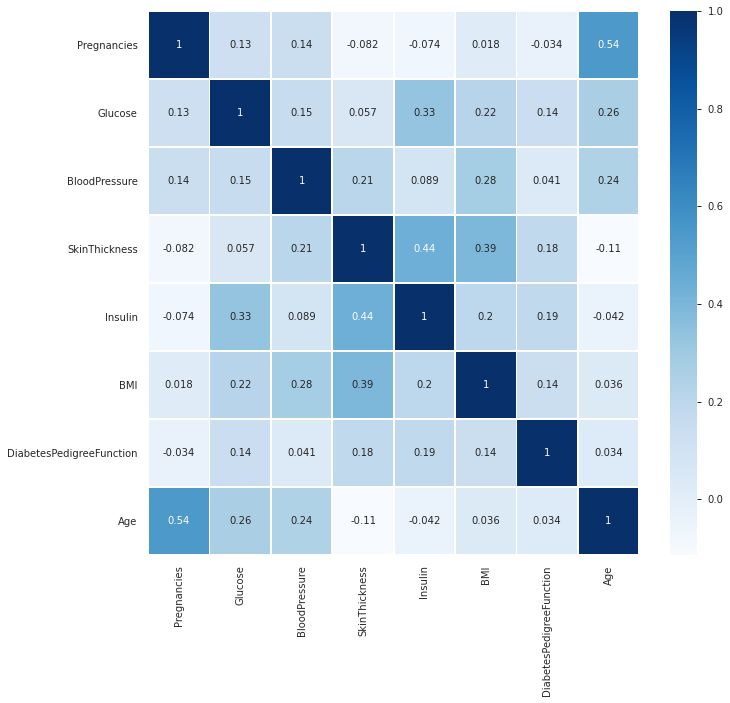

In [16]:
plt.figure(figsize=(11,10))
correlation = X.corr()
sns.heatmap(correlation,linewidth = 0.7,cmap = 'Blues',annot = True)

In [17]:
X = X.loc[data.index]
y = y.loc[data.index]

## Data Scaling

### Note: DataScaling will not be required for this Notebook, since we are using Boosting method of Decision Trees which doesn't mind the distance between the data points

**Although here are the steps to implement the same**

- from sklearn.preprocessing import RobustScaler
- cols = X.columns
- transformer = RobustScaler().fit(X[cols])
- X[cols] = transformer.transform(X[cols])

## Data Modeling

- Step 1. Divide the Dataset into Test and Train set, where 75% data belongs to Train set and 25% to test size

- Step 2: Using the imported library train your model and then fit it.

- Using RandomSearchCV, try to get the best paramters for best results

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.25,random_state = 100)

In [19]:
from sklearn.metrics import log_loss,accuracy_score,confusion_matrix,f1_score,recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
xgb = XGBClassifier(booster ='gbtree',objective ='binary:logistic')

### you can find more information about Hyperparameter tuning using this [Github Repo](https://github.com/Lokeshrathi/HyperParamter_optimisation)

In [20]:
from sklearn.model_selection import RandomizedSearchCV

param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5,0.4],
    'n_estimators' : [100, 500, 1000,1500,2000],
    'max_depth' : [2,3,5, 6,8, 9],
    'min_child_weight' : [1, 5, 10],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1],
    'colsample_bytree' : [0.3,0.4,0.5,0.7],
    'gamma' : [0.0,0.1,0.2,0.3,0.4]
}

xgb_tuning = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst ,
                          n_iter = 5,
                        cv =6)
       
xgb_search = xgb_tuning.fit(X_train,y_train,
                           early_stopping_rounds = 5,
                           eval_set=[(X_val,y_val)],
                           verbose = False)

## checking for the best paramter values that the model took

best_param = xgb_search.best_params_
xgb = XGBClassifier(**best_param)
print(best_param)

{'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 2000, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.4, 'gamma': 0.4, 'colsample_bytree': 0.4}


In [21]:
## check the best estimators
xgb_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
y_pred = xgb_search.predict(X_val)
score0 = accuracy_score(y_pred,y_val)
#print(round(score0*100,4))
print('Score: {}%'.format(round(score0*100,4)))

Score: 83.9286%


In [23]:
## checking  'Accuracy' value using Cross Validation menthod
acc_scores1_xgb =  cross_val_score(xgb_search,X,y,n_jobs=5,
                                 cv = StratifiedKFold(n_splits=10),
                                 scoring = 'accuracy')
acc_scores1_xgb

array([0.73529412, 0.7761194 , 0.73134328, 0.74626866, 0.67164179,
       0.79104478, 0.79104478, 0.80597015, 0.79104478, 0.7761194 ])

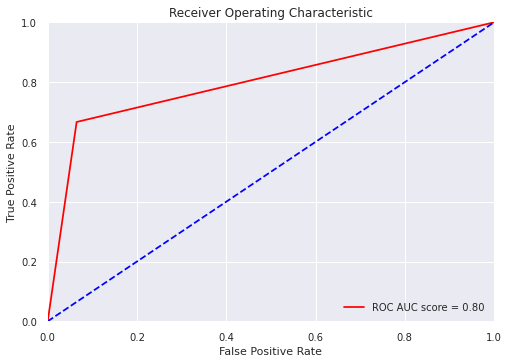

In [25]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC-AUC Curve:

- An ROC curve (Receiver Operating Characteristic curve) is a graph showing the performance of a classification model at all classification thresholds.

- Y-Axis shows the True Positive Rate
- X-Axis shows the False Positive Rate

True postive Rate is also known as Recall and is given by True Postive/(True Positive+False Negative)

False Postive Rate is given by False Postive/(False Positive+True Negative)

![Confusion Matrix](https://glassboxmedicine.files.wordpress.com/2019/02/confusion-matrix.png?w=816)

## Using Cross Validation with Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [27]:
log_scores_logi = -1 * cross_val_score(lr, X, y,
                              cv=5,
                              scoring='neg_log_loss')
acc_scores1_logi =  cross_val_score(lr,X,y,
                                 cv = 5,
                                 scoring = 'accuracy')
f_score_logi =  cross_val_score(lr,X,y,
                                 cv = 5,
                                 scoring = 'f1')

In [28]:
print("log_loss scores:\n", log_scores_logi)
print("Accuracy scores:\n", acc_scores1_logi)
print("f1_score scores:\n", f_score_logi)

log_loss scores:
 [0.53185977 0.49142894 0.53805629 0.43570244 0.44161707]
Accuracy scores:
 [0.76296296 0.76119403 0.73880597 0.82835821 0.79850746]
f1_score scores:
 [0.56756757 0.61904762 0.55696203 0.70886076 0.64      ]


In [29]:
print(acc_scores1_logi.mean())

0.7779657269209508


### This Notebook will come in handy to anyone who wants to revise the important concepts such as  
- **Hyperparamter Tuning**
- **Using Cross Validation**
- **Boosting method like XGBClassifier**

- References:
 - [Tuning](https://www.kaggle.com/angqx95/data-science-workflow-top-2-with-tuning)
 - [GridSearchCV vs Random](https://github.com/Lokeshrathi/HyperParamter_optimisation)